#STOCK PREDICTION USING LINEAR REGRESSION

In [76]:
# uploading file to colab 
from google.colab import files
uploaded = files.upload()

Saving tsla.us.txt to tsla.us (1).txt


In [77]:
!pip install pandas_ta
from sklearn.linear_model import LinearRegression # importing for linear reg model
from sklearn import metrics # importing for evaluating models
from sklearn.model_selection import train_test_split # importing for splitting the data
import matplotlib.pyplot as plt # for plots
import numpy as np # for general math calculations
from numpy import linalg as la # for linear algebra calculations
import pandas as pd # for handling datasets
import pandas_ta # for adding moving average indicators

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


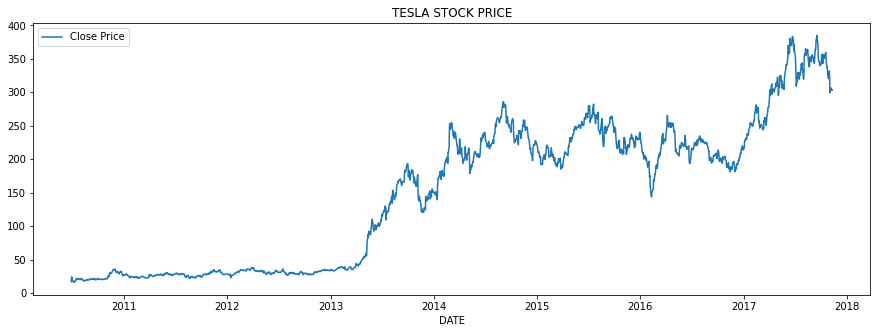

In [80]:
stock = "tsla.us.txt"
df = pd.read_csv(stock) # reading the csv file 
df.set_index(pd.DatetimeIndex(df['Date']), inplace=True) # Reindex data using a DatetimeIndex
df = df[["Open", "Close", "Volume"]] # holding only Open Close and Volume
# plotting the stock price movement 
plt.figure(figsize=(15,5)) # changing the size of the figure
plt.plot(df["Close"], label="Close Price") # plotting the Close of the stock
plt.title("TESLA STOCK PRICE") # titling the graph
plt.xlabel("DATE") # putting the label DATE in the x axis
plt.legend() # adding the labels "Stock Price" and  "EMA 10" in the graph
plt.show() # showing the graph

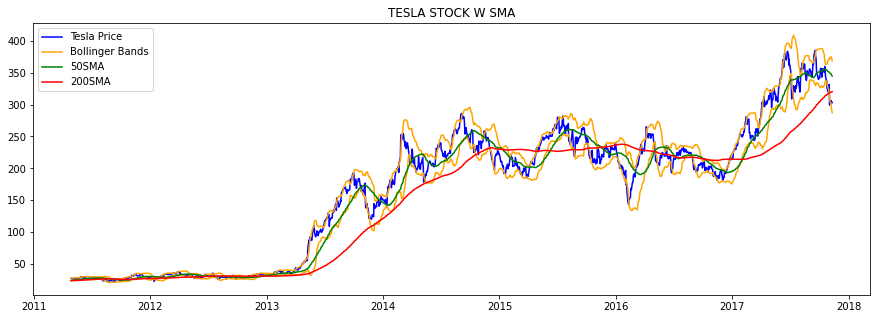

In [81]:



# Adding some new columns
df["Prev_Close"] = df.loc[:, "Close"].shift(1) # adding the previous day close
df["Prev_Volume"] = df.loc[:, "Volume"].shift(1) # adding the previous day volume

# this function will compare moving averages to get data out of them 
def calc_macd(data, len1, len2, len3):
  shortEMA = data.ewm(span=len1, adjust=False).mean()
  longEMA = data.ewm(span=len2, adjust=False).mean()

  MACD = shortEMA - longEMA # this will indicate the trend of the stock by comparing the ema's
  signal = MACD.ewm(span=len3,adjust=False).mean() # ema of the macd

  return MACD, signal

# this is the relative stock index and it says if a stock is overbought or oversold
def calc_rsi(data, period):
  delta = data.diff() # the difference of this day and the previous one
  # we want to know when the diffrence is above 0 and when it is below 0
  up = delta.clip(lower=0) # all positive points stay the same and all negative are 0
  down = -1*delta.clip(upper=0) # the opposite

  # now to see the trend we will calculate the ema 
  ema_up = up.ewm(com=period, adjust=False).mean()
  ema_down = down.ewm(com=period, adjust=False).mean()

  rs = ema_up / ema_down # that is the relative strength number
  rsi = 100 - (100/(1+rs))

  return rsi 

# this function creates two bands around the mean of the stock that are at distance 2 std's away 
# and therefore if the stock reaches is one then there is a high possibility to bounce back 
def calc_bollinger(data, period):
  mean = data.rolling(period).mean()
  std = data.rolling(period).std()

  upper_band = np.array(mean) + 2 * np.array(std)
  lower_band = np.array(mean) - 2 * np.array(std)

  return upper_band, lower_band

# Adding SMA's to the df short term and long term 
df["5SMA"] = df["Prev_Close"].rolling(5).mean() 
df["10SMA"] = df["Prev_Close"].rolling(10).mean() 
df["20SMA"] = df["Prev_Close"].rolling(20).mean() 
df["50SMA"] = df["Prev_Close"].rolling(50).mean() 
df["100SMA"] = df["Prev_Close"].rolling(100).mean() 
df["200SMA"] = df["Prev_Close"].rolling(200).mean() 

MACD, signal = calc_macd(df["Prev_Close"], 12, 26, 9) # calculating the macd(differemce of ema's) and the ema of macd)
df["MACD"] = MACD # adding macd
df["MACD_signal"] = signal # adding signal 

df["RSI"] = calc_rsi(df["Prev_Close"], 13)
df["RSI_Volume"] = calc_rsi(df["Prev_Volume"], 13)

upper, lower = calc_bollinger(df["Prev_Close"], 20)
df["Upper_Band"] = upper
df["Lower_Band"] = lower 


# calculating the percent changes through #period days and adding it to the df
labels = ["Prev_Close",	"Prev_Volume",	"200SMA",	"5SMA",	"10SMA",	"20SMA",	"50SMA", \
          "100SMA",	"MACD",	"MACD_signal",	"RSI",	"RSI_Volume",	"Upper_Band",	"Lower_Band"]
        
period = 1
new_labels = [str(period) + "d_" + label for label in labels]
df[new_labels] = df[labels].pct_change(period, fill_method="ffill")

period = 2
new_labels = [str(period) + "d_" + label for label in labels]
df[new_labels] = df[labels].pct_change(period, fill_method="ffill")

period = 5
new_labels = [str(period) + "d_" + label for label in labels]
df[new_labels] = df[labels].pct_change(period, fill_method="ffill")

period = 10
new_labels = [str(period) + "d_" + label for label in labels]
df[new_labels] = df[labels].pct_change(period, fill_method="ffill")

# dropping the NaN 
df = df.replace(np.inf, np.nan).dropna()


# visualizing some simple averages
plt.figure(figsize=(15,5)) # adjusting figsize
plt.title("TESLA STOCK W SMA")
plt.plot(df["Close"], color="blue", label="Tesla Price") 
plt.plot(df["Upper_Band"], color="orange", label="Bollinger Bands")
plt.plot(df["Lower_Band"], color="orange")
plt.plot(df["50SMA"], color="green", label="50SMA")
plt.plot(df["200SMA"], color="red", label="200SMA" )
plt.legend(loc="upper left")
plt.show()


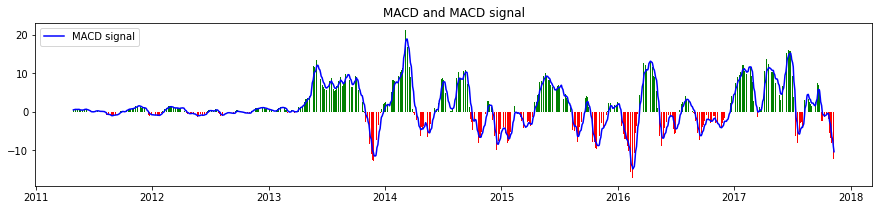

In [82]:

# plotting the MACD and the signal
plt.figure(figsize=(15,3))
# if > 0 green if < 0 red
colors = np.array(["green"] * len(df["MACD"])) # making an array of greens
colors[df["MACD"] < 0] = "red"

plt.title("MACD and MACD signal")
plt.bar(df.index.values,df["MACD"], color=colors)
plt.plot(df["MACD_signal"], color="blue", label="MACD signal")
plt.legend(loc="upper left")
plt.show()

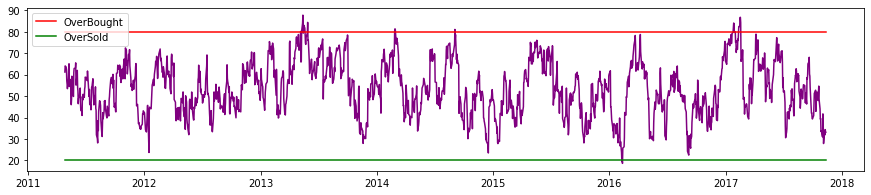

In [83]:
# this graph shows if a stock is overbought or oversold ( if it touches the green then it is oversold and therefore cheap )
plt.figure(figsize=(15,3))
plt.plot(df["RSI"], color="purple")
plt.plot( [df.index.values[0], df.index.values[-1] ] , [80,80], color="red", label="OverBought")
plt.plot( [df.index.values[0], df.index.values[-1] ], [20,20], color="green", label="OverSold")
plt.legend(loc="upper left")
plt.show()

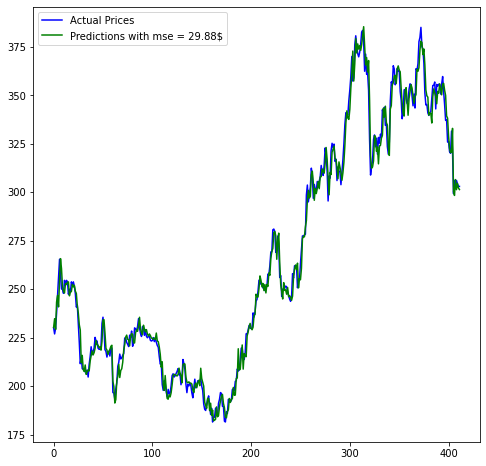

In [84]:
y = df["Close"]
X = df.drop(["Close", "Volume"], axis=1).values

# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = metrics.mean_squared_error(y_test, y_pred)

plt.figure(figsize=(8,8))
plt.plot(range(len(y_test)), y_test, color="blue", label="Actual Prices")
plt.plot(range(len(y_pred)), y_pred, color="green", label="Predictions with mse = {0:.2f}$".format(mse))
plt.legend(loc="upper left")
plt.show()


In [85]:
# Creating a virtual account too see if we would win money with those preds
def VR_trade(opens, closes, preds, start_acc=1000, thresh=0):
  acc = start_acc
  changes = []

  for i in range(len(preds)):
    if (preds[i] - opens[i])/opens[i] >= thresh:
      acc += acc*(closes[i] - opens[i])/opens[i]
    changes.append(acc)

  changes = np.array(changes)

 

  # this is the money we would have won without using the model 
  invest_total = start_acc + start_acc * ( closes[-1] - opens[0] ) / opens[0] 

  print("Investing Total : ", round(invest_total,2), \
        str(round((invest_total - start_acc)/start_acc*100,1)) + "%")
   
  print("Algo-Trading Total : ", round(acc,2), \
        str(round((acc - start_acc)/start_acc*100,1)) + "%")
  
  plt.figure(figsize=(8,8))
  plt.plot(range(len(changes)), changes, label="Strategy outcome = " +str(round((acc - start_acc)/start_acc*100,1)) + "%")
  plt.title("LR strategy for " + stock)
  plt.legend(loc="upper left")
  plt.savefig(stock+"LR.png")
  plt.show()
  
   

Investing Total :  1317.98 31.8%
Algo-Trading Total :  1102.44 10.2%


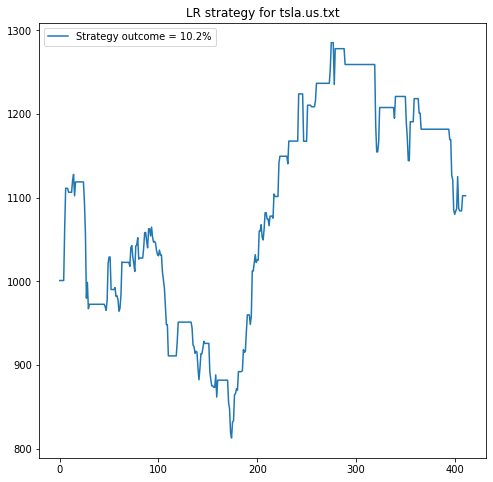

In [86]:
VR_trade(X_test.T[0], y_test, y_pred, 1000, 0)